In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from keras.datasets import mnist

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [40]:
data_t = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [41]:
data_t.head(6)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
# turning the data into numpy array so we can mainpulate it 
data_matrix = np.array(data_t) # (42000 , 785)
# get the data dimension
m , n = data_matrix.shape
# shuffle the matrix around the first axis (rows)
np.random.shuffle(data_matrix)
# get the first 1000 samples and transpose it 
data_dev = data_matrix[0:1000].T   #(785, 1000)
# get the Y (labels) and X ( the inputs)
Y_d = data_dev[0] # (1,1000)
X_d = data_dev[1:n] #(784, 1000)

X_d = X_d/255.

# get the training data from the rest

data_train = data_matrix[1000:m].T #(785, 41000)
Y_train = data_train[0] #(1, 41000)
X_train = data_train[1:n] #(784 , 41000)

X_train = X_train/255.

In [43]:
#dimensions to get better understanding
print(m,
n,
X_d.shape,
Y_d.shape,
X_train.shape,
Y_train.shape)

42000 785 (784, 1000) (1000,) (784, 41000) (41000,)


In [44]:
def init_params():
    W1 = np.random.normal(size=(10, 784)) * np.sqrt(1./(784))
    b1 = np.random.normal(size=(10, 1)) * np.sqrt(1./10)
    W2 = np.random.normal(size=(10, 10)) * np.sqrt(1./20)
    b2 = np.random.normal(size=(10, 1)) * np.sqrt(1./(784))
    return W1, b1, W2, b2


# implementing RelU which will be our activation function
def RelU(x):
    return np.maximum(x,0)
# implementing softmax to output the probability for eact neuron in the output layer
def softmax(Z):
    exp = np.exp(Z - np.max(Z))
    return exp / exp.sum(axis=0)

# implementing forward progation 
def forward_propgation(W1, b1, W2, b2, X):
#     calculating Z values for the first layer
    Z1 = W1.dot(X) + b1
    A1 = RelU(Z1)
# calculating activation values for the output layer
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1 , A1 , Z2 , A2
    
# implementing one hot vector representation
def one_hot(Y):
#     implementing one-hot vectors in matrix of size (examples size m , 10)
    one_hot = np.zeros((Y.size, Y.max()+1)) # (41000, 10)
    one_hot[np.arange(Y.size), Y] =1 #(0...41000 , Y) = 1
    return one_hot.T

# define the derivative of the activation function 
def dd_RELU(X):
    return X >0

#  backward propagation
def backward_propgation(Z1, A1,Z2,A2,W2,X,Y,m):
    one_hot_Y = one_hot(Y)
    dZ2 = (A2- one_hot_Y) #10,41000 same as on_hot(Y)
    dW2 = (1/m) * (dZ2.dot(A1.T)) # 10 , 10
    db2 = (1/m) * np.sum(dZ2,1) # 10, 41000
    dZ1 = W2.T.dot(dZ2)*dd_RELU(Z1) # 10, 41000
    dW1 = (1/m) * (dZ1.dot(X.T)) #10, 784
    db1 = (1/m )* np.sum(dZ1,1) # 10, 41000
    return dW1, db1, dW2, db2
# updating the biases and weights using the learning rate (hyper-parameter)
def update_params(W1,W2,b1,b2,dW1 , dW2 , db1,db2,alpha,i):
    W1 -= alpha * dW1
    b1 -= alpha * db1[i%10]
    W2 -= alpha * dW2
    b2 -= alpha * db2[i%10]

    return W1, b1, W2, b2
    
    

In [45]:
# use the argmax to convert our probalilities to one-hot vector can be compared with Y
def get_predictions(A2):
    return np.argmax(A2, 0)
# get accuracy by simply dividing correct.predictions / 41000 (total size)
def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size
# our learning algorithms 
def gred_descent(X, Y, alpha, iterations):
#     initilize weights and biases
    m = X.shape[1]
    W1,b1,W2,b2 = init_params()
#     iterate to reach the optimal 
    for i in range(iterations):
        Z1 , A1 , Z2 , A2 =  forward_propgation(W1, b1, W2, b2, X) #forward propagation to substitute in the model
        dW1, db1, dW2, db2 = backward_propgation(Z1,A1,Z2,A2,W2,X,Y,m) #backward propagation to calculate errors
        W1, b1, W2, b2 = update_params(W1,W2,b1,b2,dW1 , dW2 , db1,db2,alpha,i)# update our praramters and loop again
        if (i+1)%50 == 0: #prints iterations and accuracy every 100 iterations
            print(f"Iteration: {i+1} / {iterations}")
            prediction = get_predictions(A2)
            print(f'{get_accuracy(prediction, Y): %}')
    return W1, b1, W2, b2
    

In [46]:
W1, b1, W2, b2 = gred_descent(X_train, Y_train, 0.10, 800)

Iteration: 50 / 800
 76.356098%
Iteration: 100 / 800
 84.182927%
Iteration: 150 / 800
 86.463415%
Iteration: 200 / 800
 87.665854%
Iteration: 250 / 800
 88.541463%
Iteration: 300 / 800
 89.143902%
Iteration: 350 / 800
 89.612195%
Iteration: 400 / 800
 89.958537%
Iteration: 450 / 800
 90.268293%
Iteration: 500 / 800
 90.558537%
Iteration: 550 / 800
 90.778049%
Iteration: 600 / 800
 90.960976%
Iteration: 650 / 800
 91.114634%
Iteration: 700 / 800
 91.268293%
Iteration: 750 / 800
 91.404878%
Iteration: 800 / 800
 91.536585%


In [47]:
flatened_weight1 = W1.flatten()
flatened_weight2 = W2.flatten()
flatened_bias1 = b1.flatten()
flatened_bias2 = b2.flatten()


data_b = {
    'bias 1': flatened_bias1.flatten(),
    'bias 2': flatened_bias2.flatten()
}
data_W1 = pd.DataFrame(flatened_weight1, columns=['W1'])
data_W2 = pd.DataFrame(flatened_weight2, columns=["W2"])
data_b = pd.DataFrame(data_b)

# Apply some formatting and styling
pd.options.display.float_format = "{:.2f}".format  # Format numerical values to 2 decimal places
data_W1.index.name = 'Index'                      
data_W2.index.name = 'Index'     
data_b.index.name = 'Index'   


print(data_W1)
print(data_W2.head())
print(data_b.head()) #our adjusted weights and biases

         W1
Index      
0     -0.02
1     -0.02
2     -0.06
3      0.01
4      0.03
...     ...
7835  -0.04
7836   0.02
7837   0.01
7838  -0.01
7839  -0.07

[7840 rows x 1 columns]
         W2
Index      
0     -0.47
1     -0.65
2      0.58
3     -0.35
4     -0.25
       bias 1  bias 2
Index                
0       -0.15   -0.01
1        0.85   -0.02
2       -0.21   -0.02
3       -0.27   -0.04
4        0.12    0.01


In [48]:
# make predications from  weights and data_set
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_propgation(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
#     get the image (784 , 1) vector
    current_image = X_train[:, index, None]
#     make prediction using this image (forward prop)
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    
#     print results to compare
    print("Prediction: ", prediction)
    print("Label: ", label)
# show the image
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [0]
Label:  0


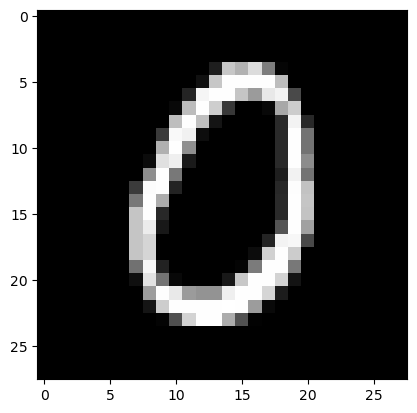

Prediction:  [9]
Label:  9


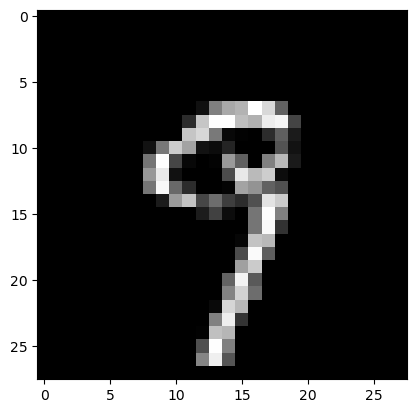

Prediction:  [2]
Label:  2


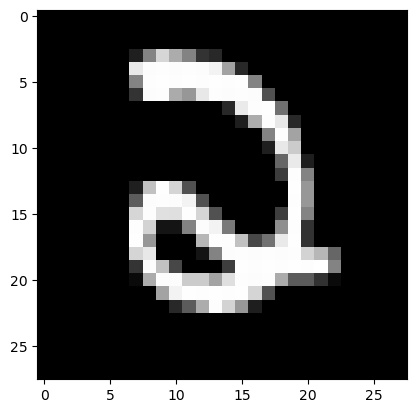

Prediction:  [6]
Label:  6


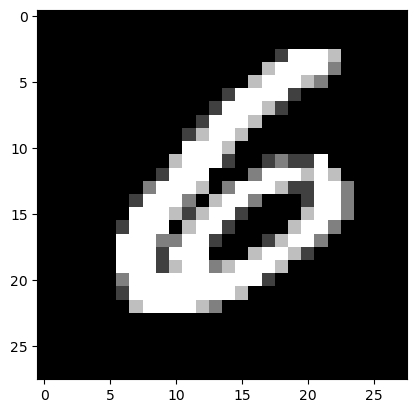

In [50]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)